In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [57]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the data

In [58]:
# file paths
train_path = "../data/preprocessed/train_vectors_scaled.csv"
test_path = "../data/preprocessed/test_vectors_scaled.csv"
gen_path = "../data/preprocessed/generalisation_vectors_scaled.csv"

In [59]:
# load the dataframes
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
gen_df = pd.read_csv(gen_path)

In [60]:
def preprocess(df, label_encoder = None):
    # get target features
    data_df = df.drop(columns=['Type'])
    data_df.drop(columns=['is_synthetic'], inplace = True, errors ='ignore')
    data_df = data_df.reindex(sorted(data_df.columns), axis=1)
    target_df = df['Type']

    # encode target labels
    if label_encoder is None:
        label_encoder = LabelEncoder()
        label_encoder.fit(target_df)
    target_df = label_encoder.transform(target_df)

    # drop ip, high volume traffic
    data_df = data_df.drop(columns=['victim IP num'])

    X = data_df.to_numpy()
    y = target_df

    return X, y, label_encoder

In [61]:
# preprocess the datasets
X_train_, y_train_, target_label_encoder =  preprocess(train_df)
X_test, y_test, _ =  preprocess(test_df, label_encoder=target_label_encoder)
X_gen, y_gen, _ =  preprocess(gen_df, label_encoder=target_label_encoder)

In [62]:
print(X_train_.shape, X_test.shape, X_gen.shape)

(2941485, 29) (1233449, 29) (2446687, 29)


In [63]:
y_train_.shape

(2941485,)

In [64]:
# train test split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_, y_train_, test_size=0.2, random_state=42)

In [65]:
print(X_train.shape, X_valid.shape, X_test.shape, X_gen.shape)

(2353188, 29) (588297, 29) (1233449, 29) (2446687, 29)


# Train the model

In [66]:
# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, n_estimators = 500)

# Train the classifier on the training data and evaluate on the validation set
xgb_classifier.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=['merror'], early_stopping_rounds=5)

c:\Users\Maya\.conda\envs\ddos\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Maya\.conda\envs\ddos\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-merror:0.17551
[1]	validation_0-merror:0.16789
[2]	validation_0-merror:0.15188
[3]	validation_0-merror:0.16242
[4]	validation_0-merror:0.15476
[5]	validation_0-merror:0.14375
[6]	validation_0-merror:0.13737
[7]	validation_0-merror:0.13091
[8]	validation_0-merror:0.12778
[9]	validation_0-merror:0.12769
[10]	validation_0-merror:0.12442
[11]	validation_0-merror:0.12030
[12]	validation_0-merror:0.11711
[13]	validation_0-merror:0.11324
[14]	validation_0-merror:0.11277
[15]	validation_0-merror:0.11062
[16]	validation_0-merror:0.11000
[17]	validation_0-merror:0.10766
[18]	validation_0-merror:0.10325
[19]	validation_0-merror:0.10280
[20]	validation_0-merror:0.10226
[21]	validation_0-merror:0.10139
[22]	validation_0-merror:0.10036
[23]	validation_0-merror:0.09913
[24]	validation_0-merror:0.09749
[25]	validation_0-merror:0.09563
[26]	validation_0-merror:0.09401
[27]	validation_0-merror:0.09274
[28]	validation_0-merror:0.09226
[29]	validation_0-merror:0.08976
[30]	validation_0-me

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

Accuracy: 0.781789113291267


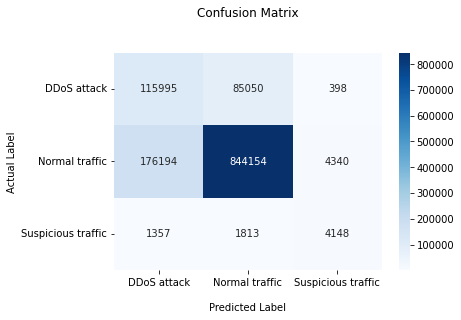

In [67]:
# Make predictions on the test data
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_test, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

Accuracy: 0.9814447464460978


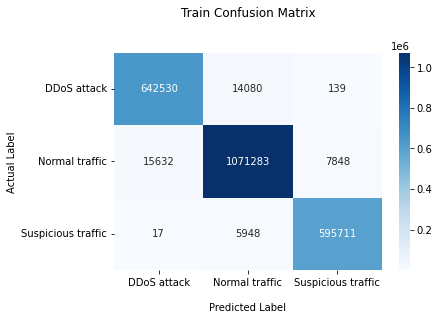

In [68]:
# Make predictions on the train data
y_pred = xgb_classifier.predict(X_train)

# Calculate accuracy of the model
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_train, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Train Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

Accuracy: 0.9798741112057345


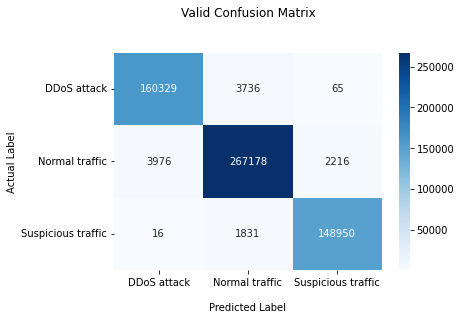

In [69]:
# Make predictions on the valid data
y_pred = xgb_classifier.predict(X_valid)

# Calculate accuracy of the model
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_valid, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Valid Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

Accuracy: 0.7979202080200696


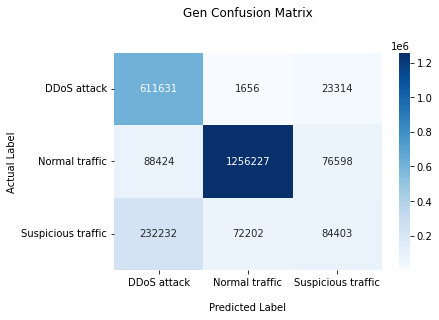

In [70]:
# Make predictions on the gen data
y_pred = xgb_classifier.predict(X_gen)

# Calculate accuracy of the model
accuracy = accuracy_score(y_gen, y_pred)
print("Accuracy:", accuracy)

cf_matrix = confusion_matrix(y_gen, y_pred)

class_names = target_label_encoder.inverse_transform([0,1,2])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt = 'd', xticklabels=class_names, yticklabels=class_names)

ax.set_title('Gen Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label')

## Display the visualization of the Confusion Matrix.
plt.show()

In [71]:
feature_importance= xgb_classifier.feature_importances_

# Map feature importance scores to feature names

feature_names = train_df.reindex(sorted(train_df.columns), axis=1).drop(columns=['Type', 'is_synthetic']).columns
feature_importance_map = dict(zip(feature_names, feature_importance))

# Sort feature importance scores
sorted_feature_importance = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

# Print feature importance scores
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

High volume traffic: 0.37727653980255127
DNS: 0.07219225913286209
ICMP: 0.060405731201171875
Significant flag: 0.05655015632510185
Source IP count: 0.055459532886743546
Suspicious traffic: 0.05162983387708664
CLDAP: 0.050962939858436584
NTP: 0.04469272121787071
Attack duration: 0.039610862731933594
SYN Attack: 0.039114803075790405
Data speed: 0.03391748666763306
Avg packet len: 0.023652032017707825
Generic UDP: 0.02323497086763382
Port number: 0.02005169168114662
is_weekday: 0.013216647319495678
time_of_day: 0.01048795972019434
Packet speed: 0.010432918556034565
TCP Anomaly: 0.005162945948541164
Memcached: 0.004597200080752373
IPv4 fragmentation: 0.001875899382866919
SSDP: 0.0017183838644996285
CoAP: 0.0012732089962810278
TFTP: 0.0009689010912552476
other_attack_codes: 0.0009573043789714575
WSD: 0.0005570257781073451
CHARGEN: 0.0
RDP: 0.0
RIP: 0.0
SNMP: 0.0
